In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
persons=['00','01','02','03','04','05','06','07','08','09']
files=[];mapping={};labels=[];paths=[]
import os
cnt=0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if dirname[42:44] in persons:
            files.append(filename)
            if dirname[45:] not in mapping.keys():
                mapping[dirname[45:]]=cnt
                cnt+=1
            labels.append(mapping[dirname[45:]])
            paths.append(os.path.join(dirname, filename))
    

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [29]:
len(paths),len(files),len(labels)

(20000, 20000, 20000)

In [30]:
labels[0],paths[0]

(0, '/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0067.png')

# Start

In [31]:
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torch.optim import Adam
import torchvision.transforms as transforms
from torchvision.models import resnet18
from matplotlib import pyplot as plt

# **transform function** + **Custom dataset class**

In [32]:
transform=transforms.Compose([
    transforms.Resize((224,224),antialias=True),
    #for converting grayscale to RGB -> necessary as resnet is trained on RGB colour images.
    transforms.Grayscale(num_output_channels=3),
    
    #Data Augmentation
    transforms.RandomHorizontalFlip(),    # 50% of time flip image along x-axis
    transforms.RandomRotation(10), 
    transforms.ToTensor(),
])

class Gestures(Dataset):
    def __init__(self,paths,labels):
        self.paths=paths
        self.labels=labels
    def __len__(self):
        return len(self.paths)
    def __getitem__(self,ind):
        x=Image.open(self.paths[ind]);y=self.labels[ind]
        return transform(x),y

    
ratio=0.9;l=len(paths)
train_data=Gestures(paths[0:int(ratio*l)],labels[0:int(ratio*l)])
test_data=Gestures(paths[int(ratio*l):],labels[int(ratio*l):])

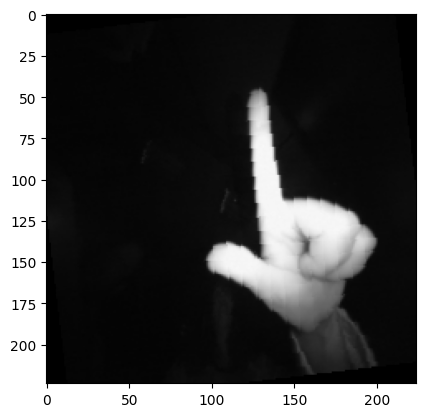

In [64]:
img=Image.open(paths[0])

plt.imshow(transform(img).permute(1,2,0))
plt.show()

In [34]:
len(train_data),len(test_data)

(18000, 2000)

# DataLoader

In [35]:
train_loader=DataLoader(train_data,batch_size=64,shuffle=True)
test_loader=DataLoader(test_data,batch_size=64,shuffle=True)
len(train_loader),len(test_loader)

(282, 32)

# **Model Architecture**

In [36]:
model=resnet18(pretrained=True)
model.fc=nn.Sequential(*[
    nn.Linear(in_features=512,out_features=10)
])
for i in model.parameters():
    i.requires_grad=False

for i in model.fc.parameters():
    i.requires_grad=True
    
for i in model.layer4.parameters():
    i.requires_grad=True
    
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
device=torch.device('cpu')
if torch.cuda.is_available():
    device=torch.device('cuda')
device

device(type='cuda')

# **Training**

In [39]:
lr=0.001;epochs=100
optimizer=Adam(params=model.parameters(),lr=lr)
loss_fn=nn.CrossEntropyLoss()
model=model.to(device)


def evaluate(model,test_loader,loss_fn):
    with torch.no_grad():
        track_loss=0
        num_correct=0
        for i,(imgs,labels) in enumerate(test_loader):
            imgs=imgs.to(device);labels=labels.to(device)
            pred=model(imgs)
            num_correct+=(torch.argmax(pred,dim=1)==labels).type(torch.float).sum().item()
            loss=loss_fn(pred,labels)
            track_loss+=loss.item()
        print(f'validation_loss: {track_loss/(len(test_loader))}  | accuracy: {num_correct*100/((len(test_loader))*64)}')
        return num_correct*100/((len(test_loader))*64)


loss_tracking=[];accuracy_tracking=[]
for epoch in range(epochs):
    track_loss=0
    num_correct=0
    for i,(imgs,labels) in enumerate(train_loader):        
        optimizer.zero_grad()
        imgs=imgs.to(device);labels=labels.to(device)
        pred=model(imgs)
        num_correct+=(torch.argmax(pred,dim=1)==labels).type(torch.float).sum().item()
        loss=loss_fn(pred,labels)
        track_loss+=loss.item()
        loss.backward()
        optimizer.step()
        if i%50==0:
            print(f'Batch-{i+1} |  avg_loss till now: {track_loss/(i+1)}  | accuracy: {num_correct*100/((i+1)*64)}')
            evaluate(model,test_loader,loss_fn)
    print('-------------------------------------\n')
    print(f'epoch:{epoch} epoch_loss: {track_loss/(len(train_loader))}  | accuracy: {num_correct*100/((len(train_loader))*64)}')
    loss_tracking.append(track_loss/(len(train_loader)))
    acc=num_correct*100/((len(train_loader))*64)
    accuracy_tracking.append(acc)
    temp=evaluate(model,test_loader,loss_fn)
    if temp>85 and acc>85 and abs(temp-acc)<=6: break
    print('_____________________________________\n\n')
    
    

Batch-1 |  avg_loss till now: 2.4879965782165527  | accuracy: 6.25
validation_loss: 1.4259572476148605  | accuracy: 52.880859375
Batch-51 |  avg_loss till now: 0.18430627323687077  | accuracy: 94.6078431372549
validation_loss: 0.04529456236923579  | accuracy: 96.2890625
Batch-101 |  avg_loss till now: 0.10107299552926112  | accuracy: 97.07611386138613
validation_loss: 0.11870469638961367  | accuracy: 94.189453125
Batch-151 |  avg_loss till now: 0.07353889692223181  | accuracy: 97.92011589403974
validation_loss: 0.04220140477991663  | accuracy: 96.240234375
Batch-201 |  avg_loss till now: 0.058281677338961904  | accuracy: 98.35976368159204
validation_loss: 0.25468131963862106  | accuracy: 89.84375
Batch-251 |  avg_loss till now: 0.04989929077961293  | accuracy: 98.60557768924303
validation_loss: 0.1334923304966651  | accuracy: 93.26171875
-------------------------------------

epoch:0 epoch_loss: 0.045319103420561786  | accuracy: 98.47074468085107
validation_loss: 0.16591735428664833  |

# Saving trained model

In [41]:
torch.save(model.state_dict(), 'trained_model.pth')

# **Inference time**

# Loading the trained model

In [50]:
model2 = resnet18(pretrained=False)  # No need to download pretrained weights
model2.fc = nn.Sequential(*[
    nn.Linear(in_features=512, out_features=10)
])

# Load the saved weights
model2.load_state_dict(torch.load('trained_model.pth'))

model2.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [55]:
reverse_mapping={mapping[i]:i for i in mapping.keys()}  # Just defining reverse mapping

# Making Predictions

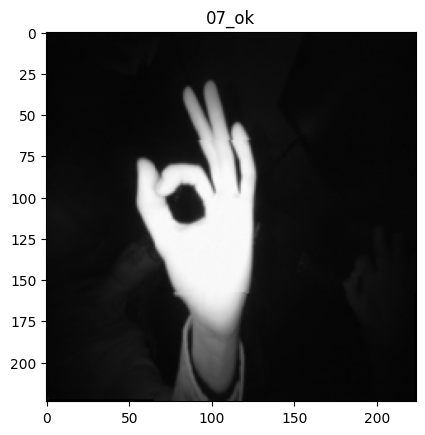

In [62]:
img=Image.open('/kaggle/input/leapgestrecog/leapGestRecog/00/07_ok/frame_00_07_0003.png')
img=transform(img).to(device)
model2.to(device)
output=model2(img.unsqueeze(0)).argmax(dim=-1).item()
plt.imshow(img.cpu().permute(1,2,0))
plt.title(reverse_mapping[output])
plt.show()